In [3099]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import scale

In [3100]:
def get_next_max(frame_, stock_name, start_date, end_date, next_days):
    frame = frame_.loc[frame_["stock_name"] == stock_name]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    
    next_column = []
    for i in range(frame.shape[0]):
        next_column.append(frame["StockValue"][i:next_days+i].max())
        
    frame["max"] = next_column
    frame[f"max_next_{next_days}"] = (frame["max"] - frame["StockValue"]) / frame["StockValue"]
    frame = frame.iloc[:-next_days,:]
    del frame["max"]
    
    return frame

In [3101]:
def get_next_min(frame_, stock_name, start_date, end_date, next_days):
    frame = frame_.loc[frame_["stock_name"] == stock_name]
    frame = frame.loc[frame.index > start_date]
    frame = frame.loc[frame.index < end_date]
    
    next_column = []
    for i in range(frame.shape[0]):
        next_column.append(frame["StockValue"][i:next_days+i].min())
        
    frame["min"] = next_column
    frame[f"min_next_{next_days}"] = (frame["min"] - frame["StockValue"]) / frame["StockValue"]
    frame = frame.iloc[:-next_days,:]
    del frame["min"]
    
    return frame

In [3102]:
frame_ = pd.read_pickle("frame_whole_BIST50")

In [3479]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [3629]:
start_date = "01-01-2010"
end_date = "31-07-2018"
next_days = 30

In [3630]:
# specific stock training
stock_name = "ANACM"
frames = get_next_max(frame_, stock_name, start_date, end_date, next_days)
frames = get_next_min(frames, stock_name, start_date, end_date, next_days)

In [3631]:
frames['target'] = np.where((frames[f"max_next_{next_days}"] >= 0.10) &
                            (frames[f"min_next_{next_days}"] >= 0)
                            ,1,0)

In [3632]:
frames.target.value_counts()

0    1792
1     286
Name: target, dtype: int64

In [3633]:
frames = frames.sample(500) 

In [3634]:
frames.target.value_counts()

0    423
1     77
Name: target, dtype: int64

In [3635]:
data = frames

In [3636]:
# Features and Target
y = data[["target"]]
targets = y

features = data.drop("target", axis=1)
X = features

In [3637]:
del X["stock_name"]
del X[f"max_next_{next_days}"]
del X[f"min_next_{next_days}"]
del X["StockValue"]
del X["StockValue_momentum"]
del X["MA_7"]
del X["MA_14"]
del X["MA_20"]
del X["MA_50"]
del X["MA_100"]
del X["MA_200"]

In [3638]:
X['marketV_to_bookV'] = X['marketV_to_bookV'].astype(float)

In [3639]:
frames

,MA_7,MA_14,MA_20,MA_50,MA_100,MA_200,MA_7_CH,MA_7_CH_CH,MA_14_CH,MA_14_CH_CH,...,StockValue,StockValue_momentum,market_positive,market_positive_ma_10,stock_name,volume,volume_ma_14,max_next_30,min_next_30,target
2010-07-02,0.817557,0.821429,0.820020,0.830924,0.809621,0.765429,-0.000144,0.054324,-0.000385,0.027545,...,0.8109,99.047270,0.840183,0.429156,ANACM,66875.0,3.569991e+05,0.086077,0.000000,0
2010-11-08,1.155671,1.153736,1.147495,1.062322,0.951741,0.878412,0.001848,-0.087496,0.002823,-0.069014,...,1.1601,100.337312,0.427928,0.446621,ANACM,1448560.0,1.551154e+06,0.090337,-0.060167,0
2018-01-30,3.098700,3.050264,2.970305,2.569644,2.345028,2.193794,0.008759,-0.028560,0.013638,0.039326,...,3.1027,105.033852,0.361765,0.548343,ANACM,2116654.0,8.884232e+06,0.122732,-0.101815,0
2011-01-07,1.331371,1.291750,1.268355,1.189516,1.098407,0.965576,0.007188,0.011497,0.006701,0.054780,...,1.3424,109.147085,0.394068,0.552478,ANACM,190708.0,5.560968e+05,0.002905,-0.101088,0
2011-10-28,1.280229,1.279093,1.274805,1.229074,1.342947,1.336362,0.000858,-0.212571,0.000206,-0.167517,...,1.2780,99.385644,0.487705,0.457377,ANACM,201660.0,4.737923e+05,0.021674,-0.142410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-10-14,1.280229,1.269214,1.273825,1.204074,1.369350,1.339276,0.000135,-0.229272,0.001499,-0.100484,...,1.2898,101.551059,0.766129,0.580269,ANACM,741493.0,1.019428e+06,0.012327,-0.150256,0
2011-09-20,1.228243,1.205079,1.174715,1.284472,1.391824,1.335867,0.008070,-0.060942,0.007177,3.945301,...,1.2780,112.549538,0.911661,0.595319,ANACM,991993.0,7.459526e+05,0.074257,-0.030986,0
2013-09-16,1.091971,1.072043,1.100630,1.214638,1.258958,1.271540,-0.005365,0.007578,-0.009860,0.066576,...,1.1256,99.145600,0.944099,0.550862,ANACM,1170608.0,7.909792e+05,0.094083,-0.008529,0
2013-09-06,1.051429,1.101593,1.152825,1.236340,1.269177,1.273898,-0.013755,0.127049,-0.010556,0.143456,...,1.0535,84.557348,0.550360,0.421402,ANACM,314591.0,5.069524e+05,0.168961,0.000000,1


In [3640]:
# Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020, stratify=y)

In [3641]:
# Translate these sets into XGBoost-compatible dense matrices
d_train = xgb.DMatrix(X_train.values, label=y_train.values, feature_names=X_train.columns)
d_validation = xgb.DMatrix(X_test, label=y_test.values, feature_names=X_test.columns)

In [3642]:
# Parametrize a watch list to follow the training performance
watch_list = [(d_train, 'train'), (d_validation, 'validation')]

In [3643]:
# Parameters
params = {"eta": 0.01, 
          "tree_method" : "hist",
          "grow_policy" : 'depthwise',
          "max_depth" : 6, 
          "subsample" : 0.9, 
          "colsample_bytree" : 0.9,
          "min_child_weight" : 1,
          "objective" : 'binary:hinge', 
           # "base_score" : perc_def,
          "scale_pos_weight" : 1,
           # "n_estimators" : 1000, 
          "eval_metric" : "auc",
          "seed" : 13,
          "gamma" : 0.11,
          "nthread" : 14,
          "reg_alpha" : 0,
          "verbosity" : 1}

MODEL_NUMBER_OF_ROUNDS = 2000
MODEL_EARLY_STOPPING_ROUNDS = 500

In [3644]:
model = xgb.train(params=params,
                        dtrain=d_train,
                        num_boost_round=MODEL_NUMBER_OF_ROUNDS,
                        evals=watch_list,
                        early_stopping_rounds=MODEL_EARLY_STOPPING_ROUNDS
)

[01:25:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	validation-auc:0.50000
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 500 rounds.
[1]	train-auc:0.50000	validation-auc:0.50000
[2]	train-auc:0.50000	validation-auc:0.50000
[3]	train-auc:0.50000	validation-auc:0.50000
[4]	train-auc:0.50000	validation-auc:0.50000
[5]	train-auc:0.50000	validation-auc:0.50000
[6]	train-auc:0.50000	validation-auc:0.50000
[7]	train-auc:0.50000	validation-auc:0.50000
[8]	train-auc:0.50000	validation-auc:0.50000
[9]	train-auc:0.50000	validation-auc:0.50000
[10]	train-auc:0.50000	validat

[166]	train-auc:0.91936	validation-auc:0.61372
[167]	train-auc:0.91936	validation-auc:0.61372
[168]	train-auc:0.91936	validation-auc:0.61372
[169]	train-auc:0.92742	validation-auc:0.61372
[170]	train-auc:0.92742	validation-auc:0.61372
[171]	train-auc:0.92742	validation-auc:0.61372
[172]	train-auc:0.92742	validation-auc:0.61372
[173]	train-auc:0.92742	validation-auc:0.61372
[174]	train-auc:0.92742	validation-auc:0.61372
[175]	train-auc:0.92742	validation-auc:0.61372
[176]	train-auc:0.92742	validation-auc:0.61372
[177]	train-auc:0.92742	validation-auc:0.61372
[178]	train-auc:0.92742	validation-auc:0.61372
[179]	train-auc:0.92742	validation-auc:0.61372
[180]	train-auc:0.92742	validation-auc:0.61372
[181]	train-auc:0.92742	validation-auc:0.61372
[182]	train-auc:0.92742	validation-auc:0.61372
[183]	train-auc:0.92742	validation-auc:0.61372
[184]	train-auc:0.92742	validation-auc:0.61372
[185]	train-auc:0.92742	validation-auc:0.61372
[186]	train-auc:0.92742	validation-auc:0.61372
[187]	train-a

[341]	train-auc:1.00000	validation-auc:0.61372
[342]	train-auc:1.00000	validation-auc:0.61372
[343]	train-auc:1.00000	validation-auc:0.61372
[344]	train-auc:1.00000	validation-auc:0.61372
[345]	train-auc:1.00000	validation-auc:0.61372
[346]	train-auc:1.00000	validation-auc:0.61372
[347]	train-auc:1.00000	validation-auc:0.61372
[348]	train-auc:1.00000	validation-auc:0.61372
[349]	train-auc:1.00000	validation-auc:0.61372
[350]	train-auc:1.00000	validation-auc:0.61372
[351]	train-auc:1.00000	validation-auc:0.61372
[352]	train-auc:1.00000	validation-auc:0.61372
[353]	train-auc:1.00000	validation-auc:0.61372
[354]	train-auc:1.00000	validation-auc:0.61372
[355]	train-auc:1.00000	validation-auc:0.61372
[356]	train-auc:1.00000	validation-auc:0.61372
[357]	train-auc:1.00000	validation-auc:0.61372
[358]	train-auc:1.00000	validation-auc:0.61372
[359]	train-auc:1.00000	validation-auc:0.61372
[360]	train-auc:1.00000	validation-auc:0.61372
[361]	train-auc:1.00000	validation-auc:0.61372
[362]	train-a

[516]	train-auc:1.00000	validation-auc:0.61372
[517]	train-auc:1.00000	validation-auc:0.61372
[518]	train-auc:1.00000	validation-auc:0.61372
[519]	train-auc:1.00000	validation-auc:0.61372
[520]	train-auc:1.00000	validation-auc:0.61372
[521]	train-auc:1.00000	validation-auc:0.61372
[522]	train-auc:1.00000	validation-auc:0.61372
[523]	train-auc:1.00000	validation-auc:0.61372
[524]	train-auc:1.00000	validation-auc:0.61372
[525]	train-auc:1.00000	validation-auc:0.61372
[526]	train-auc:1.00000	validation-auc:0.61372
[527]	train-auc:1.00000	validation-auc:0.61372
[528]	train-auc:1.00000	validation-auc:0.61372
[529]	train-auc:1.00000	validation-auc:0.61372
[530]	train-auc:1.00000	validation-auc:0.61372
[531]	train-auc:1.00000	validation-auc:0.61372
[532]	train-auc:1.00000	validation-auc:0.61372
[533]	train-auc:1.00000	validation-auc:0.61372
[534]	train-auc:1.00000	validation-auc:0.61372
[535]	train-auc:1.00000	validation-auc:0.61372
[536]	train-auc:1.00000	validation-auc:0.61372
[537]	train-a

In [3645]:
best_iteration = model.best_ntree_limit
print("Best iteration: " + str(best_iteration))

Best iteration: 76


In [3646]:
ypred = model.predict(d_validation, ntree_limit=best_iteration)

In [3647]:
ypred

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

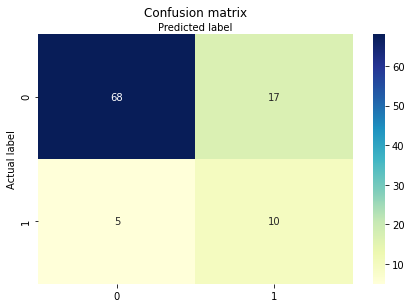

In [3648]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

if params["objective"] == "binary:hinge":
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
        # create heatmap
    sns.heatmap(pd.DataFrame(confusion_matrix(y_test, ypred)), annot=True, 
                cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [3649]:
def predict(xs):
    return model.predict(xgb.DMatrix(xs))

### VALIDATION

In [3650]:
BIST50 = ["TUPRS", "VAKBN","TOASO","KRDMD","MGROS","DOHOL","AKBNK","TKFEN","FROTO","GARAN","KOZAA","HALKB",
         "KORDS","TCELL","ENKAI","KOZAL","VESTL","TSKB","YKBNK","SODA","TTKOM","SKBNK","BIMAS","ODAS","PETKM",
          "SISE","ANACM", "ARCLK", "YATAS", "EREGL", "SASA", "ALARK", "SAHOL", "AEFES", "EKGYO", "THYAO",
         "HEKTS", "PGSUS", "ISCTR", "TRKCM", "KCHOL", "ISFIN", "ASELS", "TAVHL","IPEKE","ULKER","CCOLA",
         "GUBRF","AGHOL", "ENJSA"]

In [3651]:
frame_ = pd.read_pickle("frame_whole_BIST50")

In [3652]:
stock_name = "ANACM"
start_date = "01-07-2018"
end_date = "31-07-2019"

In [3653]:
next_days = 20

In [3654]:
frame = get_next_max(frame_, stock_name, start_date, end_date, next_days)

In [3655]:
del frame["stock_name"]

In [3656]:
del frame[f"max_next_{next_days}"]

In [3657]:
del frame["StockValue"]
del frame["MA_7"]
del frame["MA_14"]
del frame["MA_20"]
del frame["MA_50"]
del frame["MA_100"]
del frame["MA_200"]
del frame["StockValue_momentum"]

In [3658]:
frame['marketV_to_bookV'] = frame['marketV_to_bookV'].astype(float)

In [3659]:
frame

,MA_7_CH,MA_7_CH_CH,MA_14_CH,MA_14_CH_CH,MA_20_CH,MA_20_CH_CH,MA_50_CH,MA_50_CH_CH,MA_100_CH,MA_100_CH_CH,...,RSI,RSI_CH,RSI_5,RSI_5_CH,Drawdown,marketV_to_bookV,market_positive,market_positive_ma_10,volume,volume_ma_14
2018-01-08,0.009500,-0.417486,0.005142,0.428966,0.002463,0.227391,0.002768,0.001915,0.000987,0.015747,...,88.371511,0.055003,82.216104,0.059294,0.000000,1.236615,0.616071,0.612581,14552181.0,8.267451e+06
2018-01-09,0.011724,-0.395229,0.006692,0.450088,0.003627,0.247831,0.003051,0.009403,0.001265,0.044380,...,91.305874,0.052830,85.677451,0.058603,0.000000,1.268323,0.342029,0.573392,25464826.0,9.839384e+06
2018-01-10,0.014051,-0.380573,0.008313,0.467269,0.004922,0.255204,0.003356,0.018284,0.001564,0.071265,...,93.326157,0.058683,88.597319,0.056047,-0.006257,1.260396,0.296188,0.552712,13247851.0,1.050167e+07
2018-01-11,0.016401,-0.356816,0.010043,0.487416,0.006493,0.262969,0.003719,0.027156,0.001868,0.093687,...,94.168670,0.051310,90.656748,0.052989,0.000000,1.315885,0.734328,0.581265,14390951.0,1.127349e+07
2018-01-12,0.018522,-0.327878,0.011777,0.502741,0.007915,0.271107,0.004103,0.037816,0.002158,0.113988,...,93.262265,0.055706,92.086895,0.051223,-0.003015,1.311921,0.555215,0.559143,8839674.0,1.181203e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-25,0.004471,-0.627480,0.002890,0.063809,0.000902,-0.240996,-0.000661,-0.090622,0.000699,-0.011193,...,63.636364,0.024419,64.531797,0.031621,-0.190469,0.904257,0.550769,0.533756,5471576.0,4.108685e+06
2019-06-26,0.003990,-0.627749,0.003380,0.076807,0.001308,-0.211402,-0.000651,-0.091368,0.000646,-0.011424,...,60.869565,0.040080,63.970325,0.031234,-0.199081,0.894637,0.397626,0.522909,3392077.0,4.308692e+06
2019-06-27,0.003274,-0.624004,0.003333,0.082205,0.001531,-0.197240,-0.000632,-0.090277,0.000575,-0.017323,...,50.000000,0.000811,62.010181,0.025012,-0.199081,0.894637,0.630952,0.566605,5989647.0,4.529093e+06
2019-06-28,0.002372,-0.622579,0.003120,0.084511,0.001651,-0.188660,-0.000624,-0.087830,0.000451,-0.032522,...,41.176471,-0.014656,56.327969,0.012801,-0.204823,0.888224,0.555215,0.571532,2880595.0,4.317147e+06


In [3660]:
prediction = predict(frame)

In [3661]:
final_test_frame = get_next_max(frame_, stock_name, start_date, end_date, next_days)

In [3662]:
min_frame = get_next_min(frame_, stock_name, start_date, end_date, next_days)

In [3663]:
final_test_frame[f"min_next_{next_days}"] = min_frame[f"min_next_{next_days}"]

In [3664]:
final_test_frame["prediction"] = prediction

In [3665]:
final_test_frame.prediction.value_counts()

0.0    336
1.0     35
Name: prediction, dtype: int64

In [3666]:
final_test_frame["diff"] = final_test_frame.max_next_20 - abs(final_test_frame.min_next_20)

In [3667]:
final_test_frame.loc[final_test_frame.prediction == 1]

,MA_7,MA_14,MA_20,MA_50,MA_100,MA_200,MA_7_CH,MA_7_CH_CH,MA_14_CH,MA_14_CH_CH,...,StockValue_momentum,market_positive,market_positive_ma_10,stock_name,volume,volume_ma_14,max_next_20,min_next_20,prediction,diff
2018-02-22,2.879729,2.861807,2.923850,2.769742,2.499604,2.277066,-0.004647,-0.166972,-0.004482,-0.099675,...,93.577378,0.550000,0.500670,ANACM,3195462.0,5.913927e+06,0.225463,0.000000,1.0,0.225463
2018-02-23,2.890357,2.864464,2.917350,2.783678,2.508894,2.281642,-0.003705,-0.139005,-0.004213,-0.090996,...,101.279406,0.567976,0.527201,ANACM,11777771.0,6.230140e+06,0.182933,-0.015791,1.0,0.167142
2018-02-27,2.879743,2.871764,2.896450,2.809318,2.527845,2.290869,-0.002309,0.132066,-0.003672,-0.070404,...,101.626986,0.397727,0.522435,ANACM,19633371.0,7.219306e+06,0.201911,0.000000,1.0,0.201911
2018-02-28,2.893014,2.885036,2.893200,2.823810,2.537970,2.295918,-0.000960,0.003881,-0.003154,-0.064076,...,106.622941,0.479042,0.538775,ANACM,17015548.0,8.213564e+06,0.164583,0.000000,1.0,0.164583
2018-05-24,2.421900,2.497543,2.617305,2.919678,2.963430,2.565840,-0.012790,0.128551,-0.012074,0.115253,...,88.743138,0.185286,0.392446,ANACM,14999327.0,6.835232e+06,0.114757,-0.015946,1.0,0.098811
2018-06-11,2.665900,2.602114,2.544665,2.762798,2.930323,2.596291,0.006511,-0.367947,0.001488,-9.107036,...,111.475739,0.394813,0.343715,ANACM,16637780.0,1.098319e+07,0.000000,-0.106907,1.0,-0.106907
2018-06-12,2.693229,2.621071,2.557935,2.754728,2.928332,2.599569,0.007789,-0.352788,0.002827,-9.046826,...,110.822052,0.326409,0.347015,ANACM,30604771.0,1.254953e+07,0.038745,-0.088012,1.0,-0.049268
2018-06-13,2.704157,2.633271,2.570655,2.746254,2.924095,2.602745,0.007921,-0.347027,0.003799,-9.024317,...,106.860540,0.259155,0.331188,ANACM,8867995.0,1.211158e+07,0.061156,-0.068336,1.0,-0.007179
2018-06-14,2.716457,2.640221,2.587135,2.740584,2.920331,2.605833,0.007463,-0.342586,0.004234,-9.014469,...,103.754148,0.608696,0.373024,ANACM,7456269.0,1.184094e+07,0.049831,-0.078279,1.0,-0.028448
2018-06-18,2.705529,2.638450,2.601225,2.733958,2.915624,2.608914,0.005898,-0.341702,0.003938,-9.012777,...,99.069802,0.309456,0.380081,ANACM,6032038.0,1.173558e+07,0.068830,-0.061598,1.0,0.007231


In [3668]:
negative_ones = final_test_frame.loc[final_test_frame.prediction == 1].loc[final_test_frame.loc[final_test_frame.prediction == 1]["diff"]<0].shape[0]

In [3669]:
negative_ones / final_test_frame.prediction.value_counts()[1]

0.4857142857142857